In [2]:
import sys
import pandas as pd
sys.path.insert(0, '../Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from histogrammi_3D import *
# tai from ... import *

In [3]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

# Grideissä vietetty aika
## Otetaan ensiksi timestampistä difference sekuntteina

In [4]:
df['time_diff'] = df['timestamp'].diff().dt.seconds
df.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id,time_diff
0,9,2020-08-17 08:10:00.420,2406,-238,33,15,783,NaN
1,9,2020-08-17 08:10:39.420,2487,-295,34,15,784,39.0
2,9,2020-08-17 08:12:04.420,2560,-347,35,14,735,85.0
3,9,2020-08-17 08:42:10.420,2618,-391,35,14,735,1806.0
4,9,2020-08-17 08:42:57.420,2667,-424,36,13,686,47.0


# Groupataan grid_id:t time_diff columnin summana 

In [5]:
grid_ajat = df.groupby(['grid_id'])['time_diff'].sum()

# Sortataan arvot laskevaan järjestykseen
grid_ajat = grid_ajat.sort_values(ascending=False)

# Scatter plotti sekä barplot 15 gridistä, joissa vietetty eniten aikaa

Text(0.5, 1.0, 'Grid_id ja vietetyn ajan jakauma ')

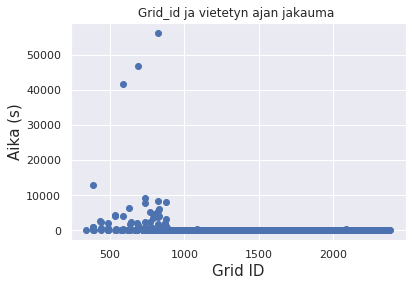

In [6]:
plt.scatter(grid_ajat.index, grid_ajat.values)
plt.xlabel('Grid ID', fontsize=15)
plt.ylabel('Aika (s)', fontsize=15)
plt.title('Grid_id ja vietetyn ajan jakauma ')

[Text(0, 0.5, 'aika (s)'), Text(0.5, 0, 'grid ID')]

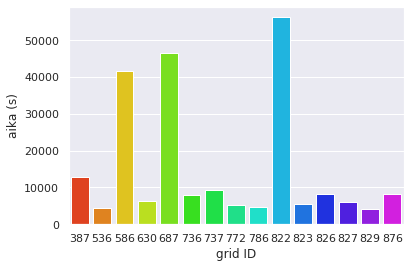

In [7]:
snsbar1 = sns.barplot(grid_ajat.index[:15], grid_ajat.values[:15],palette='gist_rainbow')
snsbar1.set(xlabel='grid ID',ylabel='aika (s)')

# Plotataan nämä 15 grid_id:tä
## Ensin otetaan kyseiset 15 grid_id x_grid ja y_grid arvot talteen

In [30]:
listx = []
listy = []

# Otetaan näiden 15 grid_id:den x_grid ja y_grid arvot talteen
for i in range(14):
    listx.append(df.loc[df.grid_id == grid_ajat.index[i]].x_grid.values.tolist())
    listy.append(df.loc[df.grid_id == grid_ajat.index[i]].y_grid.values.tolist())
    

# Muuttaa list-of-lists to list koska oon bob
flattenx = []
for sublist in listx:
    for item in sublist:
        flattenx.append(item)

flatteny = []
for sublist in listy:
    for item in sublist:
        flatteny.append(item)

# flatx ja flat y arvot dataframeen ja sieltä size 

In [31]:
gridit15 = pd.DataFrame()
gridit15['x'] = flattenx
gridit15['y'] = flatteny
gridit15 ['grid_id'] = gridit15['y'] * 50 + gridit15['x']
size = gridit15.grid_id.value_counts()

Text(0.5, 1.0, 'Punaisella ovat kyseiset 15 gridiä')

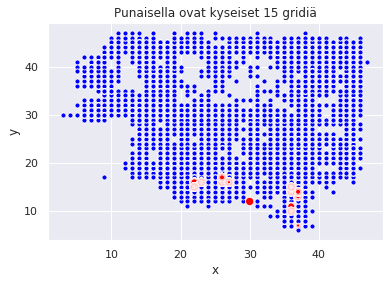

In [32]:
sns.scatterplot(df.x_grid,df.y_grid, color='blue', s=25)
sns.scatterplot(gridit15.x, gridit15.y,s=size/20, color='red').set_title('Punaisella ovat kyseiset 15 gridiä')